In [1]:
# Imports
import torch
torch.cuda.empty_cache()

import hr_dv2.transform as tr
from hr_dv2.utils import *
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from skimage.measure import label
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels
from time import time



IMG_SIZE = 350
PATCH_SIZE  = 14
PATCH_H, PATCH_W = IMG_SIZE // PATCH_SIZE, IMG_SIZE // PATCH_SIZE
FEAT_DIM = 384

transform = tr.get_input_transform(IMG_SIZE, IMG_SIZE)

In [2]:
from hr_dv2 import HighResDV2

net = HighResDV2("dinov2_vits14_reg", 4, dtype=torch.float16)
net.cuda()
net.eval()
pass

Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [3]:
shift_dists = [i for i in range(1, 3)]
transforms, inv_transforms = tr.get_shift_transforms(shift_dists, 'Moore')
net.set_transforms(transforms, inv_transforms)

In [4]:
LABEL_CONFIDENCE = 0.7
SXY_G, SXY_B = (3, 3), (80, 80)
SRGB = (13, 13, 13)
COMPAT_G, COMPAT_B = 10, 10
KERNEL = dcrf.FULL_KERNEL

def find_fg_mask(seg: np.ndarray, verbose=False) -> np.ndarray:
    # ASSUMES BG SPANS WHOLE IMAGE AND FG DOESN'T
    seg = seg.astype(bool)
    h, w, c = seg.shape
    seg_area = h * w
    masks = [seg, ~seg]
    areas = []
    bg_idx = 0
    if verbose:
        print(f"Seg area={seg_area}")
    for i, m in enumerate(masks):
        idxs = np.nonzero(m)
        min_y, max_y = np.amin(idxs[0]), np.amax(idxs[0])
        min_x, max_x = np.amin(idxs[1]), np.amax(idxs[1])
        area = (max_x - min_x) * (max_y - min_y)
        if verbose:
            print(f"{i}: area={area} ({min_x}, {min_y}, {max_x}, {max_y})")
        areas.append(area)
    bg_idx = int(np.argmax(areas))
    return masks[1 - bg_idx]

    

def object_segment(net: HighResDV2, img_arr: np.ndarray, img_tensor: torch.Tensor, single_component: bool=True, 
                   verbose: bool=False) -> np.ndarray:
    start = time()
    ih, iw, ic = img_arr.shape
    hr_tensor, _ = net.forward(img_tensor, attn='none')
    features: np.ndarray
    b, c, fh, fw = hr_tensor.shape
    features = tr.to_numpy(hr_tensor)
    reshaped = features.reshape((c, fh * fw)).T

    normed = normalise_pca(reshaped)
    cluster = KMeans(n_clusters=2, n_init='auto')
    cluster.fit(normed)
    k_means_labels = cluster.labels_

    unary = unary_from_labels(k_means_labels, 2, LABEL_CONFIDENCE, zero_unsure=False)
    d = dcrf.DenseCRF2D(iw, ih, 2)
    u = np.ascontiguousarray(unary)
    d.setUnaryEnergy(u)
    d.addPairwiseGaussian(sxy=SXY_G, compat=COMPAT_G, kernel=KERNEL,
                        normalization=dcrf.NORMALIZE_SYMMETRIC)
    d.addPairwiseBilateral(sxy=SXY_B, srgb=SRGB, rgbim=img_arr, compat=COMPAT_B, kernel=KERNEL,
                            normalization=dcrf.NORMALIZE_SYMMETRIC)
    Q = d.inference(10)
    crf_seg = np.argmax(Q, axis=0)
    crf_seg = crf_seg.reshape((ih, iw, 1))
    fg_seg = find_fg_mask(crf_seg, verbose=verbose)
    fg_seg = fg_seg.astype(np.uint8)
    if single_component:
        labels, n_components = label(fg_seg, background=0, return_num=True)
        fg_seg = labels == np.argmax(np.bincount(labels.flat, weights=fg_seg.flat))
    end = time()
    if verbose:
        print(f"Finished in {end-start}s")
    return fg_seg

In [5]:
img_paths = ["data/d3.jpg", "data/plane.jpg", "data/f1.jpg", "data/coffee.png", "data/c1.jpg"]
masks, imgs = [], []

for i, path in enumerate(img_paths):
    tensor, img = tr.load_image(path, transform)
    tensor.to(torch.float16)
    tensor = tensor.cuda()

    fg_seg = object_segment(net, np.array(img), tensor, single_component=False, verbose=False)
    tensor = tensor.cpu()

    imgs.append(img)
    masks.append(fg_seg)

Text(0.5, 0.8, 'Foreground object segmentation from DINOv2 features')

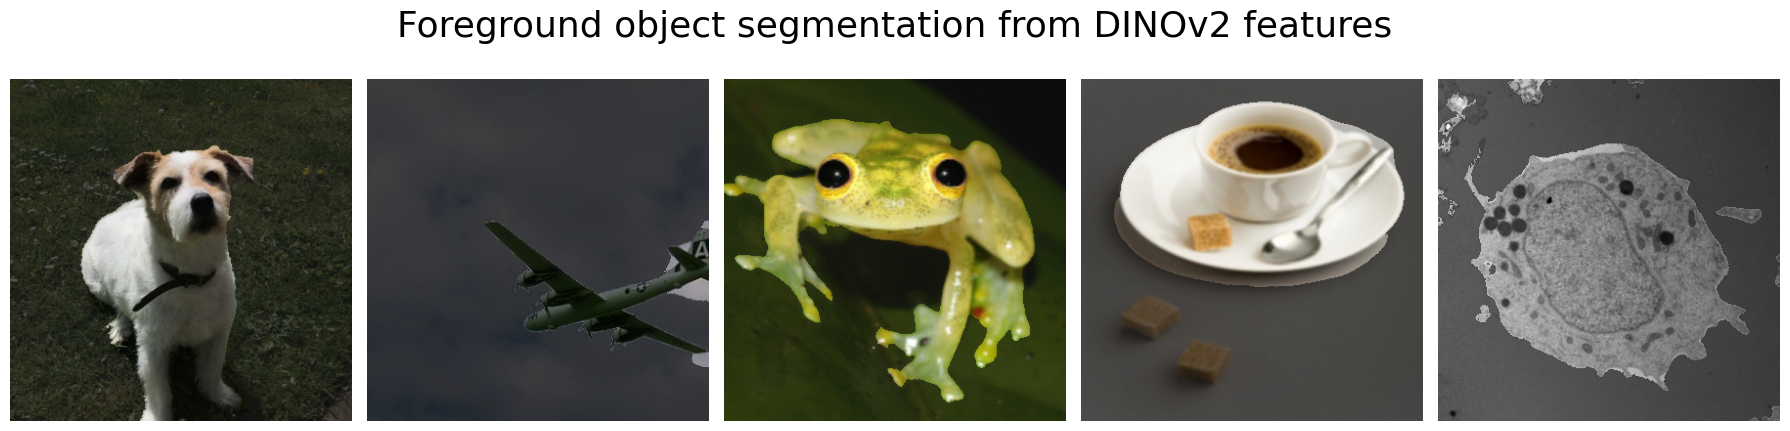

In [6]:
fig, axs = plt.subplots(ncols=len(img_paths))
fig.set_size_inches(18, 8)

for i, img in enumerate(imgs):
    ax = axs[i]
    mask = masks[i]
    alpha_mask = np.where(mask == 1, [1, 1, 1, 1], [0.35, 0.35, 0.35, 0.95])
    img = img.convert("RGBA")
    masked = (img * alpha_mask).astype(np.uint8)
    ax.imshow(masked)
    ax.set_axis_off()
fig.tight_layout()
fig.suptitle("Foreground object segmentation from DINOv2 features", fontsize=26, y=0.8)